### Ice Sales Analysis

#### 1. Data Overview

##### 1.1 Initialization

In [111]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

##### 1.2 Data Overview

In [112]:
# Import the DataFrame

url = 'https://raw.githubusercontent.com/DHE42/ice-sales-analysis/refs/heads/main/games.csv'
games_df = pd.read_csv(url)

# Print Data Overview

print("Data Head")
print(games_df.head())
print()


Data Head
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  



The Games DataFrame has 11 columns. These cover the following categories:

1) Name
2) Gaming Platform
3) Release Year
4) Genre
5) North America Sales
6) Europe Sales
7) Japan Sales
8) Other Sales
9) Critic Score
10) User Score
11) Rating.

Let's call info() to get a basic idea of the null/non-null values and data types of the columns.

In [113]:
print("Data Info")
print(games_df.info())
print()
print("Number of null values in each column:")
print(games_df.isnull().sum())

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Number of null values in each column:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales        

There are significant null values in Critic_Score, User_Score, and Rating. Rating's null values should be listed as unknown, since the values are categorical and there is no reliable way to easily estimate what the rating for each game would be. Critic_Score and User_Score should have null values replaced with the median of the non-null values in the column to restore the data as accurately as possible with as little skew, since there is moderate variability due to varying opinions on motion pictures. Year_of_Release has low variability, and therefore I will repalce the null values with the mean of the non-null values, since the mean of the column is likely to show the most reasonable year for the games with null values to have been released. 

The data types for the values in the set are not all suitable for the types of data they are holding, and will be converted in data cleaning.

In [114]:
print("Data Description")
print(games_df.describe())
print()


Data Description
       Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000  



#### 2. Cleaning and Restoring Data

##### 2.1 Handling Null Values and Standardizing Data

Name, Platform, Genre, User_Score, and Rating are all stored as an object. These should all be stored in snake case as string data types, and all values should be lower case, as well as having their leading and trailing spaces/punctuation dropped. I will also drop irregular hyphens in Genre column to standardize for accessibility. Critic_Score, User_Score, and Year_of_Release should also be stored as int64 since there's no need for decimal precision. The sales columns will remain float64, since decimal precision is needed. 

In [115]:

# Step 1: Cleaning Cateogorical Columns

# Convert column names to lower case, which ensures consistency and makes it easier to reference columns in the DataFrame.
games_df.columns = games_df.columns.str.lower()
# Convert all string values to lower case, strip leading/trailing spaces, and replace spaces with underscores
string_columns = games_df.select_dtypes(include=['object']).columns
for col in string_columns:
    games_df[col] = games_df[col].str.lower().str.strip().str.replace(' ', '_')
# Remove leading and trailing periods, question marks, and exclamation marks
for col in string_columns:
    games_df[col] = games_df[col].str.strip('.!?-')
for col in string_columns:
    games_df[col] = games_df[col].str.replace('-', '')

# Step 2: Handle missing categorical values

# Handling Categorical Columns
games_df['platform'] = games_df['platform'].fillna('unknown')
games_df['genre'] = games_df['genre'].fillna('unknown')
games_df['rating'] = games_df['rating'].fillna('unknown')
games_df['name'] = games_df['name'].fillna('unknown')

# Cleaning and Restoring Numerical Columns
# Replace NaN values in the year_of_release column with the mean of the column
mean_year = games_df['year_of_release'].mean(skipna=True)
games_df['year_of_release'] = games_df['year_of_release'].fillna(mean_year)
# Replace NaN values in the na_sales column with the median of the column
median_na_sales = games_df['na_sales'].median(skipna=True)
games_df['na_sales'] = games_df['na_sales'].fillna(median_na_sales)
# Replace NaN values in eu_sales column with the median of the column
median_eu_sales = games_df['eu_sales'].median(skipna=True)
games_df['eu_sales'] = games_df['eu_sales'].fillna(median_eu_sales)
# Replace NaN values in jp_sales column with the median of the column 
median_jp_sales = games_df['jp_sales'].median(skipna=True)
games_df['jp_sales'] = games_df['jp_sales'].fillna(median_jp_sales)
# Replace NaN values in other_sales column with the median of the column
median_other_sales = games_df['other_sales'].median(skipna=True)
games_df['other_sales'] = games_df['other_sales'].fillna(median_other_sales)
# Convert user_score to float to handle NaN values for later conversion to int64, as int64 has trouble handling NaN values
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors='coerce')
# Replace NaN values in the user_score column with the mean of the column
mean_user_score = games_df['user_score'].mean(skipna=True)
games_df['user_score'] = games_df['user_score'].fillna(mean_user_score)
# Replace NaN values in the critic_score column with median of the column
median_critic_score = games_df['critic_score'].median(skipna=True)
games_df['critic_score'] = pd.to_numeric(games_df['critic_score'], errors='coerce')
games_df['critic_score'] = games_df['critic_score'].fillna(median_critic_score)

# Step 3: Data Type Conversion

# Convert categorical columns to string.
# These columns are currently stored as object dtype, which is a generic type in pandas.
# Converting them to string dtype ensures consistency and allows for string-specific operations.
games_df['name'] = games_df['name'].astype('string')
games_df['platform'] = games_df['platform'].astype('string')
games_df['genre'] = games_df['genre'].astype('string')
games_df['rating'] = games_df['rating'].astype('string')


# Step 4: Convert applicable numerical columns to int64, which is appropriate for mathematical operations and analysis.
# This is the most space efficient manner, since these columns do not require decimal precision.
# Convert user_score to int64
games_df['user_score'] = games_df['user_score'].astype('int64')
# Convert critic_score to int64
games_df['critic_score'] = games_df['critic_score'].astype('int64')
# Convert year_of_release to int64
games_df['year_of_release'] = games_df['year_of_release'].astype('int64')

print("Data Info After Cleaning:")
print(games_df.info())
print()
print("DF Head After Cleaning:")
print(games_df.head())
print()

Data Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  string 
 1   platform         16715 non-null  string 
 2   year_of_release  16715 non-null  int64  
 3   genre            16715 non-null  string 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  int64  
 9   user_score       16715 non-null  int64  
 10  rating           16715 non-null  string 
dtypes: float64(4), int64(3), string(4)
memory usage: 1.4 MB
None

DF Head After Cleaning:
                       name platform  year_of_release        genre  na_sales  \
0                wii_sports      wii             2006       sports     41.36   
1          super

##### 2.2 Editing Specialized Jargon

There are no null values left in the DataFrame, but it looks like the platform column has opaque specialized jargon. I will replace this with plain speech in snake case to make it easier to use the DataFrame. 

In [116]:
# Replace industry jargon with descriptive values in platform column
games_df['platform'] = games_df['platform'].replace('wii', 'nintendo_wii')
games_df['platform'] = games_df['platform'].replace('nes', 'nintendo_entertainment_system')
games_df['platform'] = games_df['platform'].replace('Nintendo Entertainment System', 'nintendo_entertainment_system')
games_df['platform'] = games_df['platform'].replace('snes', 'super_nintendo_entertainment_system')
games_df['platform'] = games_df['platform'].replace('gb', 'game_boy')
games_df['platform'] = games_df['platform'].replace('gba', 'game_boy_advance')
games_df['platform'] = games_df['platform'].replace('ds', 'nintendo_ds')
games_df['platform'] = games_df['platform'].replace('3ds', 'nintendo_3ds')
games_df['platform'] = games_df['platform'].replace('xb', 'xbox')
games_df['platform'] = games_df['platform'].replace('xone', 'xbox_one')
games_df['platform'] = games_df['platform'].replace('x360', 'xbox_360')
games_df['platform'] = games_df['platform'].replace('ps', 'playstation')
games_df['platform'] = games_df['platform'].replace('ps2', 'playstation_2')
games_df['platform'] = games_df['platform'].replace('ps3', 'playstation_3')
games_df['platform'] = games_df['platform'].replace('ps4', 'playstation_4')
games_df['platform'] = games_df['platform'].replace('psp', 'playstation_portable')
games_df['platform'] = games_df['platform'].replace('psv', 'playstation_vita')
games_df['platform'] = games_df['platform'].replace('n64', 'nintendo_64')
games_df['platform'] = games_df['platform'].replace('2600', 'atari_2600')
games_df['platform'] = games_df['platform'].replace('gen', 'sega_genesis')
games_df['platform'] = games_df['platform'].replace('sat', 'sega_saturn')
games_df['platform'] = games_df['platform'].replace('dc', 'sega_dreamcast')
games_df['platform'] = games_df['platform'].replace('scd', 'sega_cd')
games_df['platform'] = games_df['platform'].replace('wiiu', 'nintendo_wii_u')
games_df['platform'] = games_df['platform'].replace('ws', 'bandai -wonderswan')
games_df['platform'] = games_df['platform'].replace('ng', 'snk_neo_geo')
games_df['platform'] = games_df['platform'].replace('gg', 'sega_game_gear')
games_df['platform'] = games_df['platform'].replace('tg16', 'turbo_graphx_16')
games_df['platform'] = games_df['platform'].replace('3do', '3do_interactive_multiplayer')
games_df['platform'] = games_df['platform'].replace('pcfx', 'pc_fx')
print("Current Head of Data:")
print(games_df.head())



Current Head of Data:
                       name                       platform  year_of_release  \
0                wii_sports                   nintendo_wii             2006   
1          super_mario_bros  nintendo_entertainment_system             1985   
2            mario_kart_wii                   nintendo_wii             2008   
3         wii_sports_resort                   nintendo_wii             2009   
4  pokemon_red/pokemon_blue                       game_boy             1996   

         genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
0       sports     41.36     28.96      3.77         8.45            76   
1     platform     29.08      3.58      6.81         0.77            71   
2       racing     15.68     12.76      3.79         3.29            82   
3       sports     15.61     10.93      3.28         2.95            80   
4  roleplaying     11.27      8.89     10.22         1.00            71   

   user_score   rating  
0           8        e  
1 

All categorical values are now in snake case, lower case, and have no extraneous spaces or punctuation. Numerical values have been stored according to necessity for decimal precision. The data has been restored through filling null values appropriately based on reasonable assumptions. Opaque specialized jargon has been replaced with plain speech for ease in DataFrame navigation. 

##### 2.3 Added Feature

There should be an additional column totalling the sales for games in all regions to see gross sales through all markets.

In [117]:
# Calculate total sales for each game
games_df['total_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales'] + games_df['other_sales']

# Reorder columns to place total_sales between other_sales and critic_score
columns = list(games_df.columns)
columns.insert(columns.index('critic_score'), columns.pop(columns.index('total_sales')))
games_df = games_df[columns]

print("DataFrame with Total Sales:")
print(games_df.head())
print()

DataFrame with Total Sales:
                       name                       platform  year_of_release  \
0                wii_sports                   nintendo_wii             2006   
1          super_mario_bros  nintendo_entertainment_system             1985   
2            mario_kart_wii                   nintendo_wii             2008   
3         wii_sports_resort                   nintendo_wii             2009   
4  pokemon_red/pokemon_blue                       game_boy             1996   

         genre  na_sales  eu_sales  jp_sales  other_sales  total_sales  \
0       sports     41.36     28.96      3.77         8.45        82.54   
1     platform     29.08      3.58      6.81         0.77        40.24   
2       racing     15.68     12.76      3.79         3.29        35.52   
3       sports     15.61     10.93      3.28         2.95        32.77   
4  roleplaying     11.27      8.89     10.22         1.00        31.38   

   critic_score  user_score   rating  
0            

#### 3. Analysis

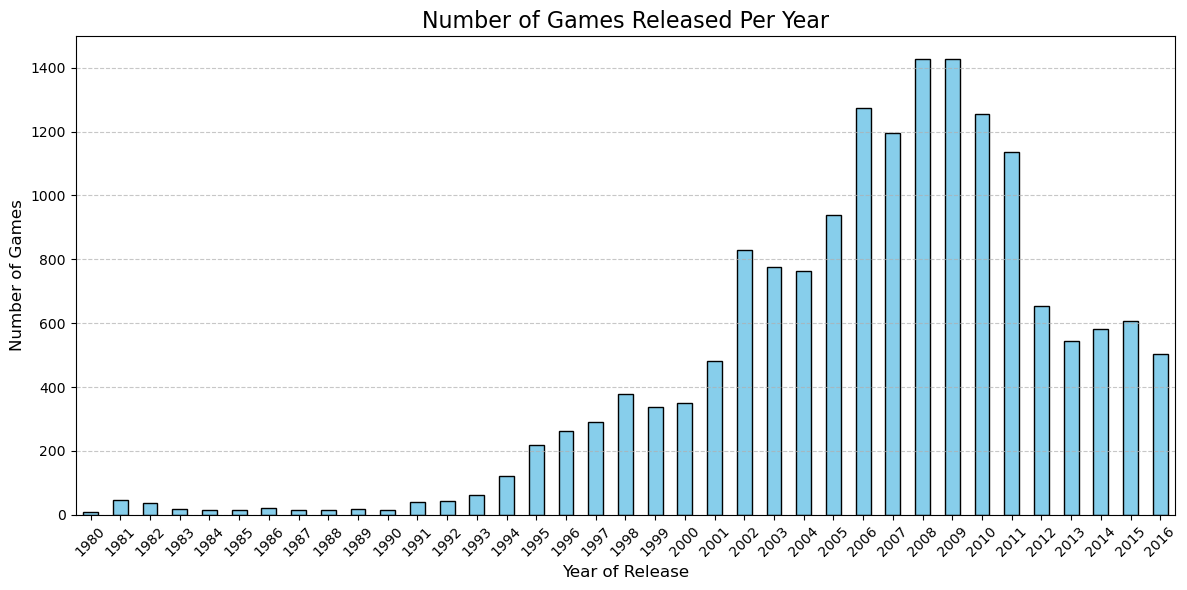


year_of_release
2008    1427
2009    1426
2006    1275
2010    1255
2007    1197
2011    1136
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: count, dtype: int64


In [120]:
# Create a bar chart for year_of_release counts
plt.figure(figsize=(12, 6))
year_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Games Released Per Year', fontsize=16)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print()

# Count occurrences of each year_of_release value
year_counts = games_df['year_of_release'].value_counts()

# Display the counts
print(year_counts)